In [1]:
!pip install numpy torch torchmetrics

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rajat95gupta/smartphone-image-denoising-dataset")
path = path + "/SIDD_Small_sRGB_Only" + "/Data"

print("Path to image files:", path)

Path to image files: /root/.cache/kagglehub/datasets/rajat95gupta/smartphone-image-denoising-dataset/versions/1/SIDD_Small_sRGB_Only/Data


In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

In [5]:
def create_dataset():
  data = []
  for filename in os.listdir(path):
    gt_path = None
    noisy_path = None
    for f in os.listdir(os.path.join(path, filename)):
        if f.startswith('GT_'):
            gt_path = os.path.join(path,filename, f)

        elif f.startswith('NOISY_'):
            noisy_path = os.path.join(path, filename, f)

    data.append({'gt':gt_path, 'noisy':noisy_path})

  return data

In [6]:
from PIL import Image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        gt_path = self.data[idx]['gt']
        noisy_path = self.data[idx]['noisy']
        gt = Image.open(gt_path)
        noisy = Image.open(noisy_path)
        if self.transform:
            gt = self.transform(gt)
            noisy = self.transform(noisy)
        return gt, noisy


In [7]:
NUM_TRAIN = 144
TARGET_SIZE = (400, 400)  # Example: Resize to 224x224 pixels

data = create_dataset()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(TARGET_SIZE),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

train = CustomImageDataset(data, transform=transform)
loader_train = DataLoader(train, batch_size=4,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomImageDataset(data, transform=transform)
loader_val = DataLoader(val, batch_size=4,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 160)))

test = CustomImageDataset(data, transform=transform)
loader_test = DataLoader(test, batch_size=4)

Show sample images from training set

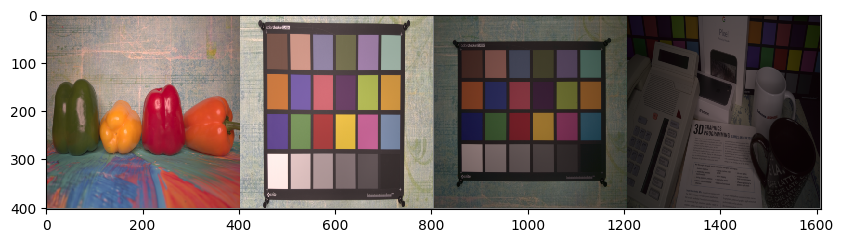

In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(loader_train)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [9]:
def flatten(x, start_dim=1, end_dim=-1):
  return x.view(-1)

In [13]:
dtype = torch.float
ltype = torch.long

def check_accuracy(loader, model):
    if hasattr(loader.dataset, 'train') and loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')

    num_correct = 0
    num_samples = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # Move inputs to device
            y = y.to(device=device, dtype=ltype)  # Ensure y is integer type for classification

            # Process y if it is one-hot encoded or has extra dimensions
            if len(y.shape) > 1:
                y = y.argmax(dim=1)  # Convert one-hot encoded y to class indices

            scores = model(x)  # Forward pass
            _, preds = scores.max(1)  # Get predicted class (index of max score)

            # Print debug info
            print(f"Preds shape: {preds.shape}, y shape: {y.shape}")

            preds = flatten(preds)
            y = flatten(y)

            print(f"Preds shap after flatteninge: {preds.shape}," +
                  f"y shape after flattening: {y.shape}")

            # Compare predictions with ground truth
            num_correct += (preds == y).sum().item()  # Count correct predictions
            num_samples += preds.size(0)  # Update total samples

        acc = float(num_correct) / num_samples  # Calculate accuracy
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

In [14]:
# Constant to control how frequently we print train loss
print_every = 100
loss_function = nn.MSELoss()

def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for

  Returns: Accuracy History, also prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)

  for e in range(epochs):

    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)

    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training modeq
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=dtype)

      scores = model(x)
      #print(f"Shape of scores: {scores.shape}, dtype: {scores.dtype}")
      #print(f"Shape of y:{y.shape}, dtype: {y.dtype}")

      loss = loss_function(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

Denoising Model

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
    return flatten(x)

class Reshape(nn.Module):
  def forward(self, x):
    return torch.reshape(x, [128,50,50])

def block(in_dim, out_dim, width):
    return nn.Sequential(
        nn.Conv2d(in_dim, in_dim, 1+2*width, padding=width),
        nn.BatchNorm2d(in_dim),
        nn.ReLU(),
        nn.Conv2d(in_dim, in_dim, 1+2*width, padding=width),
        nn.BatchNorm2d(in_dim),
        nn.ReLU(),
    )

class ConvResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, width):
        super().__init__()
        self.block = block(in_dim, out_dim, width)
        self.conv = nn.Conv2d(in_dim, out_dim, 1+2*width, padding=width)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.m = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = x + self.block(x)
        x = self.conv(x)
        x = self.m(x)

        return x

class TransConvResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, width):
      super().__init__()
      self.block = block(in_dim, out_dim, width)
      self.conv = nn.Conv2d(in_dim, out_dim, 1+2*width, padding=width)
      self.in_dim = in_dim
      self.out_dim = out_dim
      self.d = nn.ConvTranspose2d(in_dim, out_dim, kernel_size=2, stride=2)

    def forward(self, x):
      x = x + self.block(x)
      x = self.d(x)

      return x

learning_rate = 4e-3
weight_decay = 1e-3
momentum = 0.9

model = None
optimizer = None

# model = nn.Sequential(
#     nn.Conv2d(3, 16, 3, padding=1), # (B,16,400,400)
#     ConvResBlock(16, 32, 1), # (B,32,200,200)
#     nn.Dropout(),
#     ConvResBlock(32, 64, 1), # (B,64,100,100)
#     nn.Dropout(),
#     ConvResBlock(64, 128, 1), # (B,128,50,50)
#     # Flatten(), # (B, 128*50*50)
#     # nn.Linear(128*50*50, 128*50*50),
#     # nn.ReLU(),
#     # Reshape(), # (B,128,50,50)
#     TransConvResBlock(128, 64, 1), # (B, 64, 100, 100)
#     TransConvResBlock(64, 32, 1), # (B, 32, 200, 200)
#     TransConvResBlock(32, 16, 1), # (B, 16, 400, 400)
#     nn.Conv2d(16, 3, 3, padding=1) # (B, 3, 400, 400)
# )

model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1), # (B,16,400,400)
    ConvResBlock(16, 32, 1), # (B,32,200,200)
    nn.Dropout(),
    ConvResBlock(32, 64, 1), # (B,64,100,100)
    nn.Dropout(),
    ConvResBlock(64, 128, 1), # (B,128,50,50)
    nn.Upsample(scale_factor=2, mode='nearest'), # (B, 128, 100, 100)
    nn.Conv2d(128, 64, 3, padding=1), # (B, 64, 100, 100)
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(64, 32, 3, padding=1),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.Conv2d(32, 3, 3, padding=1),
)

model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate,
                      weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

# You should get at least 70% accuracy
train(model, optimizer, epochs=1)


Epoch 0, Iteration 0, loss = 0.2353
Checking accuracy on test set
Preds shape: torch.Size([4, 400, 400]), y shape: torch.Size([4, 400, 400])
Preds shap after flatteninge: torch.Size([640000]),y shape after flattening: torch.Size([640000])
Preds shape: torch.Size([4, 400, 400]), y shape: torch.Size([4, 400, 400])
Preds shap after flatteninge: torch.Size([640000]),y shape after flattening: torch.Size([640000])
Preds shape: torch.Size([4, 400, 400]), y shape: torch.Size([4, 400, 400])
Preds shap after flatteninge: torch.Size([640000]),y shape after flattening: torch.Size([640000])
Preds shape: torch.Size([4, 400, 400]), y shape: torch.Size([4, 400, 400])
Preds shap after flatteninge: torch.Size([640000]),y shape after flattening: torch.Size([640000])
Got 111766 / 2560000 correct (4.37%)



x:  tensor([[[-2.0853e-01, -5.5023e-02, -1.5161e-01,  ..., -2.8685e-02,
           1.4446e-01, -4.0528e-03],
         [-2.7771e-01,  8.0271e-04, -2.4779e-01,  ..., -3.3232e-01,
           5.9970e-02, -2.9430e-01],
         [-2.9024e-01,  1.3843e-01, -1.2872e-01,  ...,  3.6477e-02,
           4.7217e-01, -8.4241e-02],
         ...,
         [-2.5902e-01,  6.6805e-02, -1.0960e-01,  ...,  2.4409e-02,
           3.6650e-01, -1.8643e-01],
         [-2.3693e-01,  2.5543e-02, -1.4056e-01,  ..., -1.5996e-01,
           1.4160e-01, -2.8280e-01],
         [-1.2695e-01,  1.2943e-01,  4.5453e-02,  ...,  2.9010e-01,
           4.5206e-01,  4.1270e-02]],

        [[-3.0710e-01, -2.9139e-01, -3.4660e-01,  ..., -3.2327e-01,
          -2.0580e-01, -8.3501e-02],
         [-3.9341e-01, -2.3520e-01, -3.4512e-01,  ..., -2.4910e-01,
          -3.1256e-02, -6.9553e-02],
         [-4.0704e-01, -2.5185e-01, -3.7792e-01,  ..., -3.2900e-01,
          -9.2424e-02, -1.4829e-01],
         ...,
         [-1.1860e-01

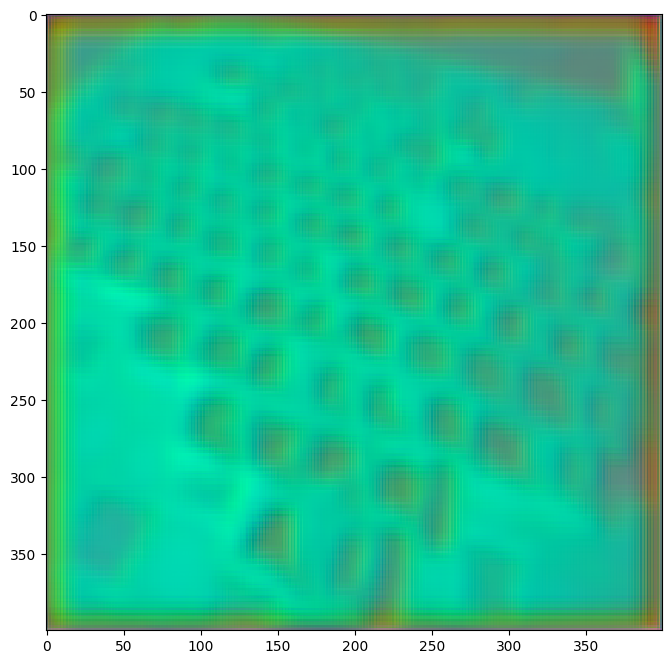

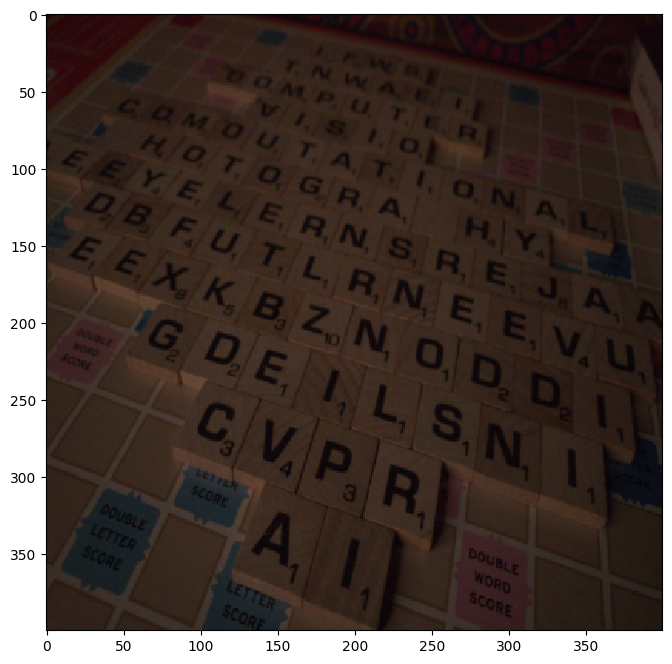

x:  tensor([[[-0.1715, -0.1001, -0.1515,  ..., -0.0389,  0.1140, -0.0096],
         [-0.2265, -0.0924, -0.2278,  ..., -0.3115,  0.0301, -0.2699],
         [-0.2343, -0.0311, -0.1631,  ...,  0.0058,  0.3853, -0.0876],
         ...,
         [-0.3126,  0.4494,  0.0441,  ...,  0.0091,  0.3167, -0.1758],
         [-0.2986,  0.3048, -0.0696,  ..., -0.1595,  0.1104, -0.2631],
         [-0.1473,  0.3861,  0.2083,  ...,  0.2598,  0.4048,  0.0368]],

        [[-0.1589, -0.1168, -0.1159,  ..., -0.2802, -0.1827, -0.0784],
         [-0.1771, -0.0396, -0.0367,  ..., -0.1998, -0.0213, -0.0577],
         [-0.1787, -0.0147, -0.0163,  ..., -0.2635, -0.0701, -0.1259],
         ...,
         [-0.2413, -0.1114, -0.2115,  ...,  0.0022,  0.0900, -0.0415],
         [-0.1530,  0.0181, -0.0530,  ...,  0.1153,  0.1840,  0.0555],
         [ 0.0248,  0.0853,  0.0727,  ..., -0.0635, -0.0234, -0.0842]],

        [[-0.0977, -0.0779, -0.1186,  ..., -0.0471,  0.0665, -0.0365],
         [-0.1940, -0.2615, -0.3479,  ...

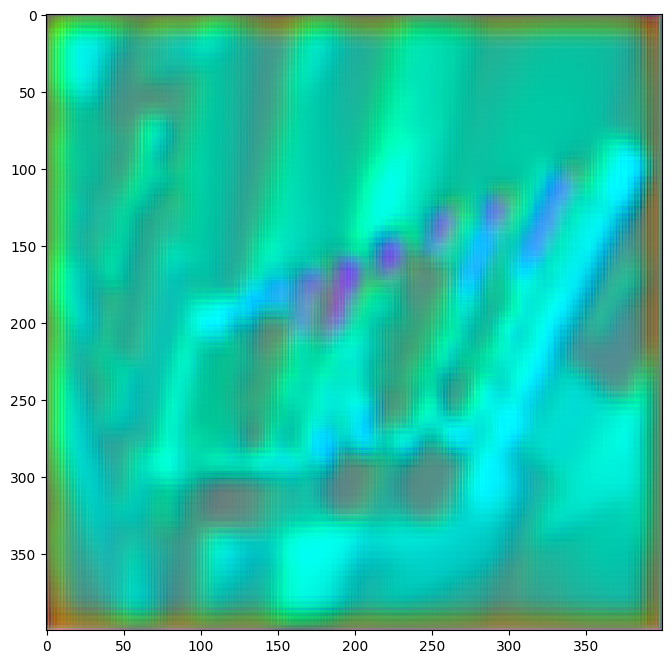

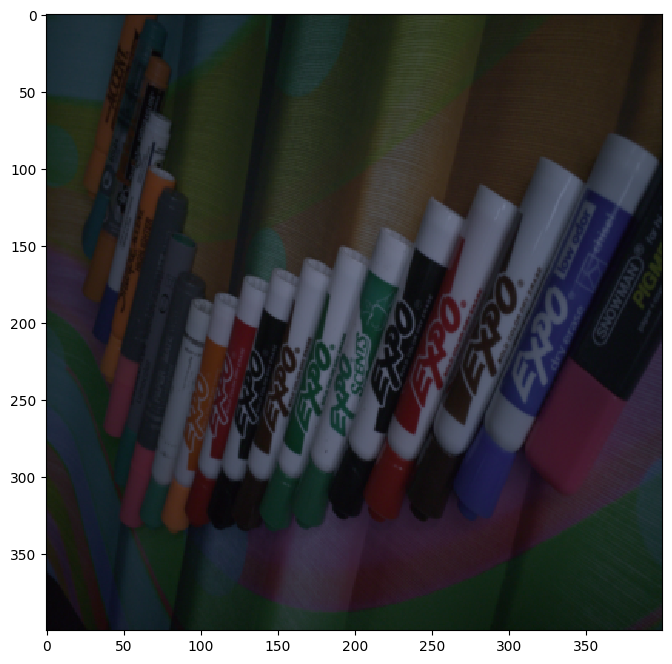

x:  tensor([[[-1.2092e-01, -1.5182e-01, -1.5160e-01,  ..., -8.5312e-02,
          -4.9216e-02, -4.4059e-02],
         [-1.5365e-01, -2.0407e-01, -2.0412e-01,  ..., -1.9111e-01,
          -1.3498e-01, -1.3255e-01],
         [-1.7241e-01, -2.3525e-01, -2.1865e-01,  ..., -1.7127e-01,
          -9.3798e-02, -1.1349e-01],
         ...,
         [-1.0815e-01, -1.8738e-01, -7.6679e-02,  ..., -1.2622e-01,
          -8.4616e-02, -1.1063e-01],
         [-1.2062e-01, -1.5327e-01, -7.3818e-02,  ..., -1.5751e-01,
          -1.3291e-01, -1.3342e-01],
         [-4.4098e-02, -1.9314e-02,  1.9344e-02,  ...,  4.5111e-02,
           6.5612e-02,  7.9755e-03]],

        [[ 4.3068e-03,  6.9612e-02,  1.2865e-01,  ..., -8.3188e-02,
          -8.0557e-02, -7.3251e-02],
         [ 4.5507e-02,  1.5372e-01,  2.6566e-01,  ..., -3.6044e-02,
          -3.4890e-02, -4.2688e-02],
         [ 4.7948e-02,  1.9875e-01,  3.1418e-01,  ..., -4.5282e-02,
          -4.3396e-02, -6.0526e-02],
         ...,
         [ 4.0667e-02

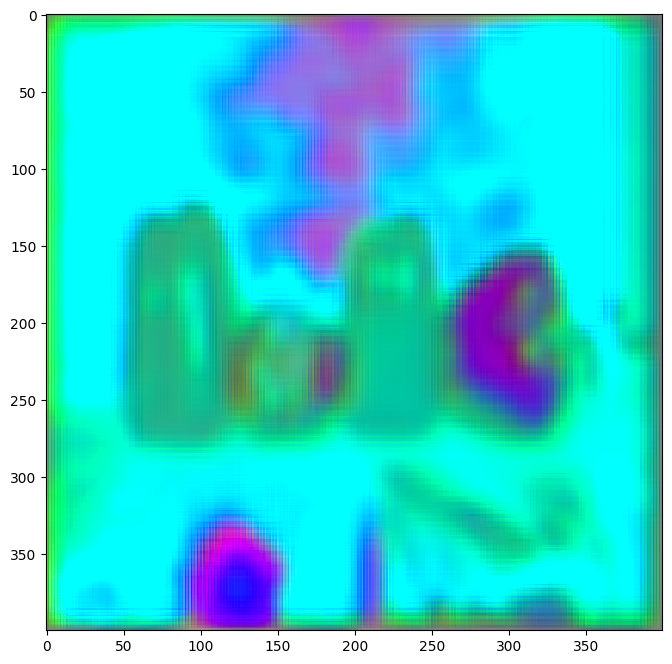

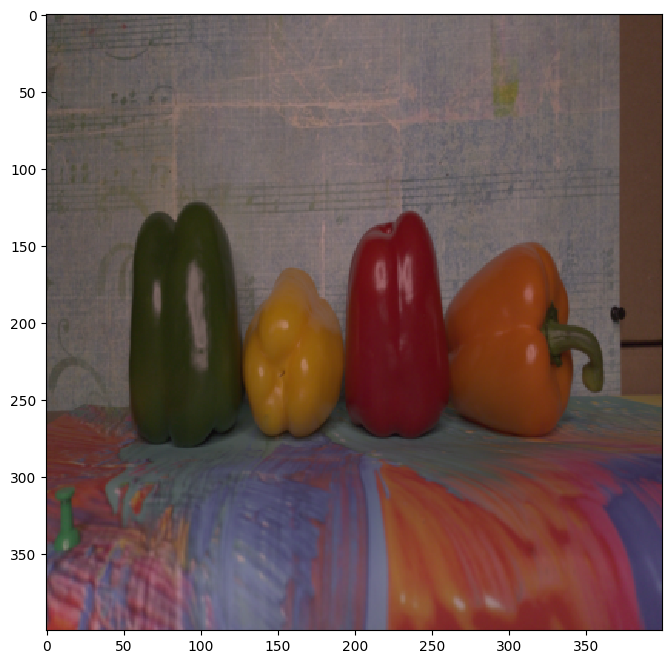

x:  tensor([[[-0.1506, -0.0925, -0.1367,  ..., -0.0670,  0.0638, -0.0198],
         [-0.1925, -0.0940, -0.2077,  ..., -0.3083, -0.0225, -0.2452],
         [-0.2151, -0.0573, -0.1749,  ..., -0.0500,  0.2656, -0.0934],
         ...,
         [-0.1199, -0.3233, -0.1984,  ..., -0.1197,  0.0361, -0.1579],
         [-0.1103, -0.2631, -0.1545,  ..., -0.1822, -0.0510, -0.1898],
         [-0.0539, -0.1455, -0.0958,  ...,  0.1119,  0.1911,  0.0065]],

        [[-0.1571, -0.1193, -0.1261,  ..., -0.2132, -0.1458, -0.0700],
         [-0.1736, -0.0417, -0.0544,  ..., -0.1140,  0.0085, -0.0275],
         [-0.1741, -0.0242, -0.0437,  ..., -0.1578, -0.0249, -0.0826],
         ...,
         [ 0.0854,  0.1633,  0.2578,  ...,  0.0385,  0.0687, -0.0155],
         [ 0.0884,  0.1193,  0.1974,  ...,  0.0984,  0.1204,  0.0528],
         [-0.0151,  0.0055,  0.0174,  ..., -0.0486, -0.0187, -0.0521]],

        [[-0.0769, -0.0497, -0.0841,  ..., -0.0699,  0.0351, -0.0300],
         [-0.1461, -0.1949, -0.2513,  ...

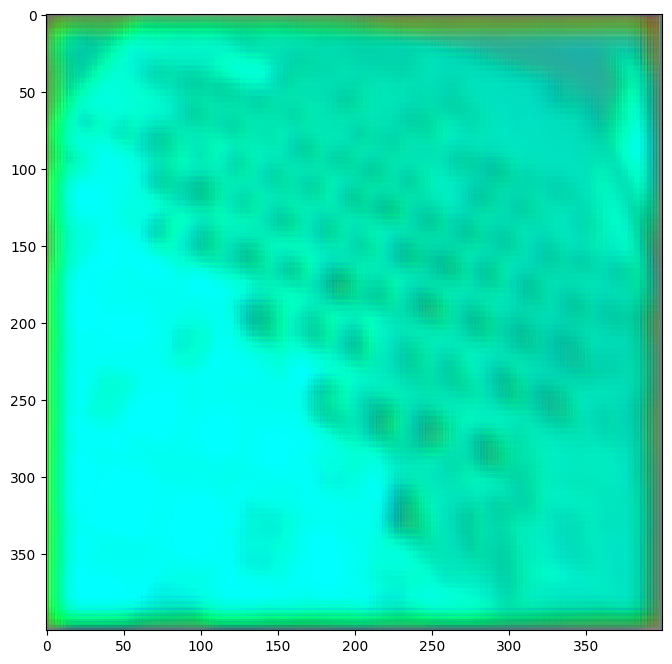

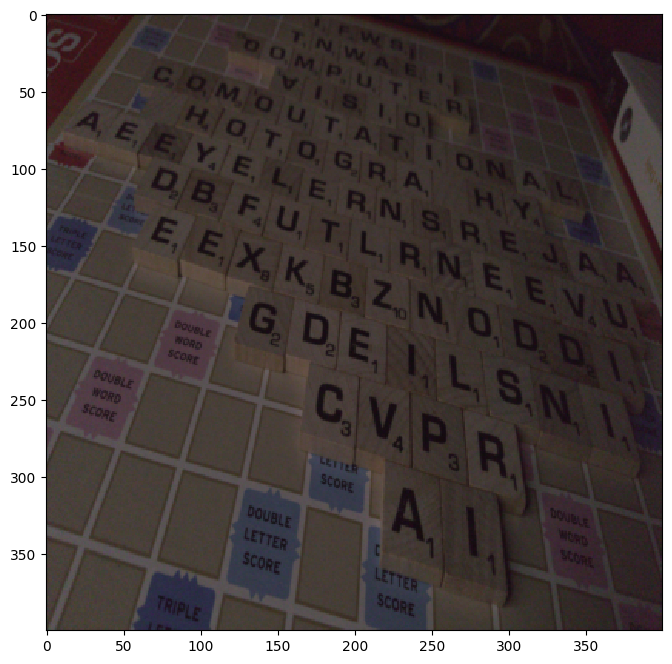

x:  tensor([[[-6.6734e-02,  1.0905e-01,  6.1428e-02,  ..., -1.4967e-01,
          -1.6586e-01, -4.6500e-02],
         [-9.3637e-02,  1.1386e-01,  9.0454e-03,  ..., -8.2236e-02,
          -1.4880e-01, -2.1371e-02],
         [-1.4524e-01,  1.8079e-01,  2.4075e-02,  ..., -1.7150e-01,
          -2.8810e-01, -7.0406e-02],
         ...,
         [-1.8925e-01, -1.9037e-01, -1.7813e-01,  ..., -1.3394e-01,
           5.2034e-02, -1.8011e-01],
         [-1.6498e-01, -1.5503e-01, -1.5124e-01,  ..., -7.7588e-02,
           5.7408e-02, -1.5446e-01],
         [-9.0004e-02, -4.0682e-02, -4.7128e-02,  ...,  9.7333e-02,
           2.2205e-01, -3.4064e-02]],

        [[-4.6286e-01, -4.8885e-01, -6.0500e-01,  ...,  9.9712e-02,
           2.0113e-02, -4.5380e-04],
         [-6.2030e-01, -5.2771e-01, -7.3185e-01,  ...,  1.8121e-01,
           1.6324e-02,  8.9628e-02],
         [-6.2447e-01, -5.9113e-01, -8.2938e-01,  ...,  3.2543e-01,
           1.4793e-01,  1.7086e-01],
         ...,
         [-5.1096e-02

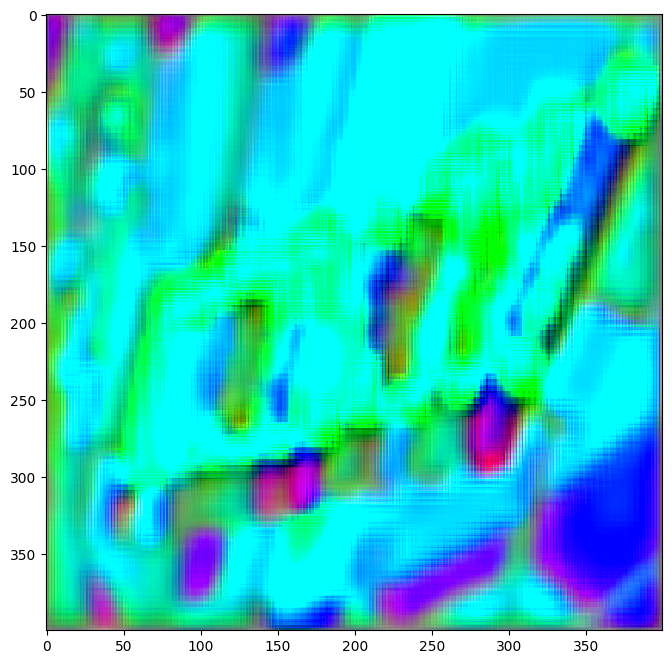

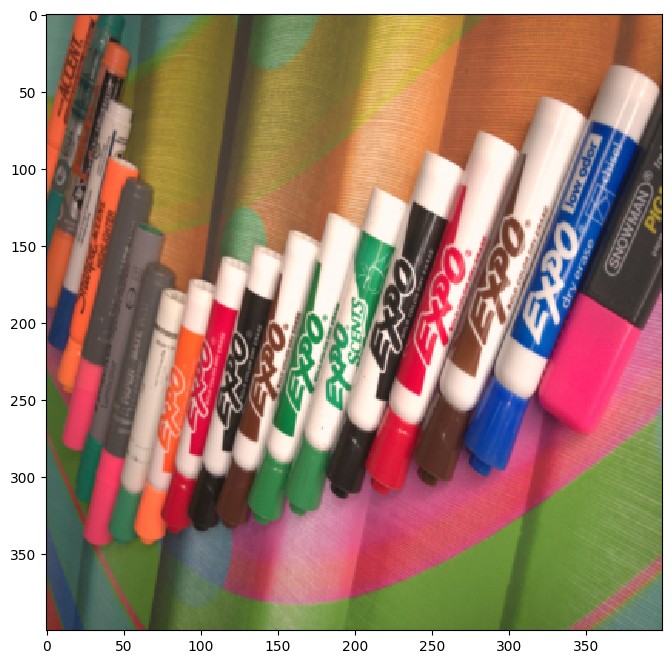

x:  tensor([[[-0.1343, -0.1255, -0.1410,  ..., -0.0721,  0.0012, -0.0353],
         [-0.1840, -0.1545, -0.2017,  ..., -0.2385, -0.0864, -0.1770],
         [-0.1952, -0.1520, -0.1813,  ..., -0.1209,  0.0570, -0.1083],
         ...,
         [-0.2016,  0.1330, -0.0689,  ..., -0.1841, -0.1884, -0.1175],
         [-0.2024,  0.0625, -0.1199,  ..., -0.1787, -0.1954, -0.1157],
         [-0.0997,  0.1251,  0.0369,  ..., -0.0208, -0.0182, -0.0134]],

        [[-0.0661, -0.0132,  0.0247,  ..., -0.1325, -0.1005, -0.0729],
         [-0.0572,  0.0516,  0.1295,  ..., -0.0640, -0.0090, -0.0402],
         [-0.0571,  0.0906,  0.1702,  ..., -0.0919, -0.0314, -0.0736],
         ...,
         [-0.0197,  0.0523,  0.0403,  ...,  0.1051,  0.0679,  0.0234],
         [ 0.0155,  0.0838,  0.0777,  ...,  0.1000,  0.0697,  0.0576],
         [ 0.0094,  0.0562,  0.0605,  ..., -0.0163, -0.0007, -0.0149]],

        [[-0.0790, -0.0889, -0.1194,  ..., -0.0334,  0.0311, -0.0113],
         [-0.1592, -0.2029, -0.2882,  ...

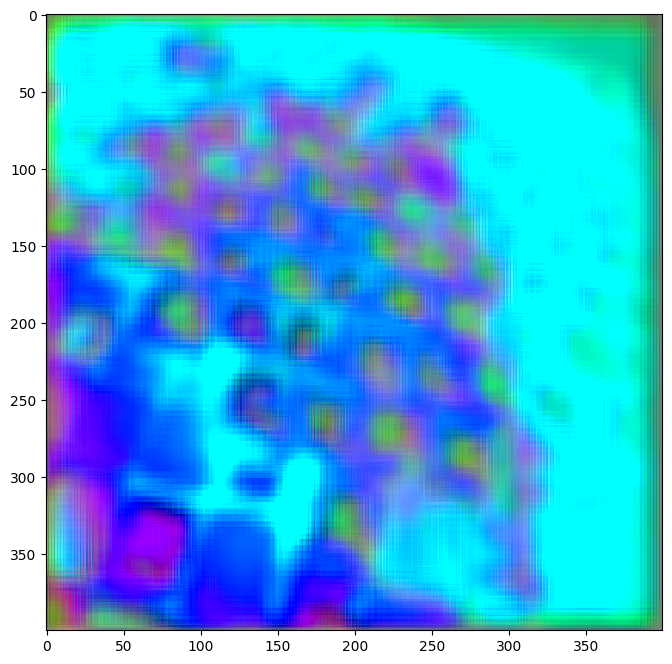

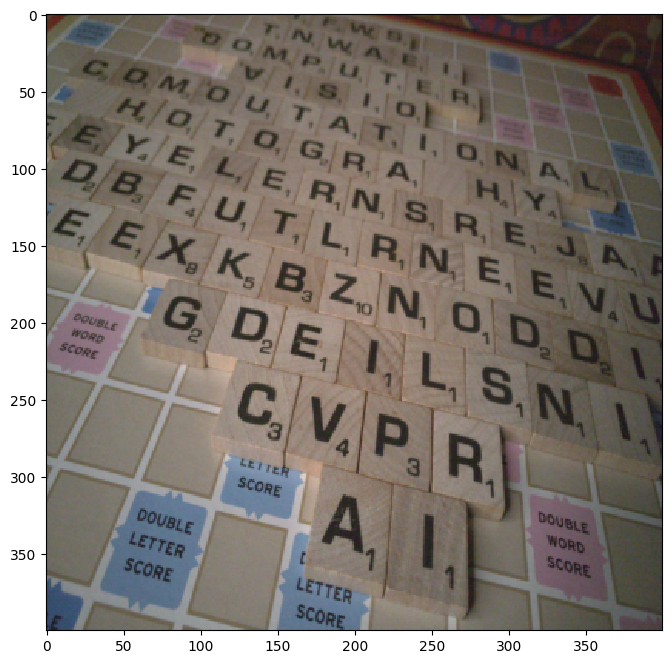

x:  tensor([[[-0.1666, -0.0912, -0.1448,  ..., -0.0565,  0.0820, -0.0152],
         [-0.2196, -0.0837, -0.2244,  ..., -0.3068, -0.0017, -0.2534],
         [-0.2362, -0.0218, -0.1659,  ..., -0.0258,  0.3118, -0.0879],
         ...,
         [-0.2541,  0.0287, -0.1192,  ...,  0.0463,  0.3952, -0.1811],
         [-0.2332, -0.0091, -0.1484,  ..., -0.1513,  0.1565, -0.2856],
         [-0.1248,  0.0985,  0.0296,  ...,  0.3047,  0.4680,  0.0468]],

        [[-0.1783, -0.1396, -0.1496,  ..., -0.2376, -0.1606, -0.0724],
         [-0.2075, -0.0660, -0.0864,  ..., -0.1435, -0.0035, -0.0370],
         [-0.2138, -0.0552, -0.0842,  ..., -0.1938, -0.0420, -0.0968],
         ...,
         [-0.1012,  0.0142,  0.0018,  ..., -0.0090,  0.0951, -0.0500],
         [-0.0552,  0.0599,  0.0558,  ...,  0.1197,  0.2019,  0.0563],
         [-0.0010,  0.0390,  0.0323,  ..., -0.0666, -0.0239, -0.0941]],

        [[-0.0879, -0.0586, -0.0980,  ..., -0.0630,  0.0452, -0.0329],
         [-0.1720, -0.2317, -0.3055,  ...

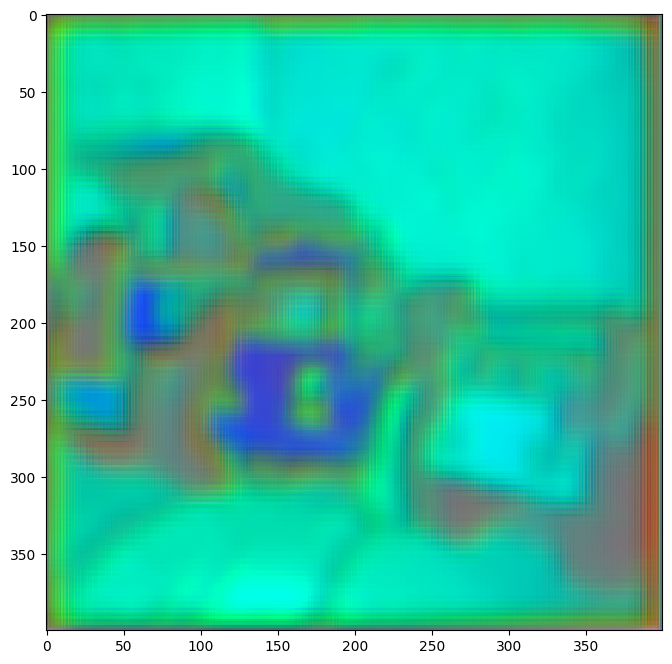

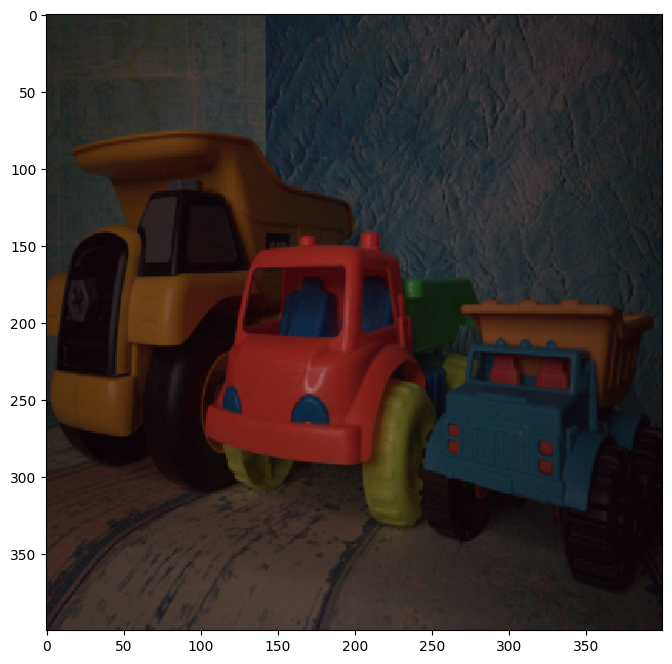

KeyboardInterrupt: 

In [16]:
model = model.to(device=device)

for t, (x, y) in enumerate(loader_test):

      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=dtype)

      scores = None

      with torch.no_grad():
        scores = model(x)

      imshow(scores[0, :, :, :].cpu())
      imshow(y[0, :, :, :].cpu())